In [106]:
import networkx as nx 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np 
from scipy.stats import linregress
import math
import json

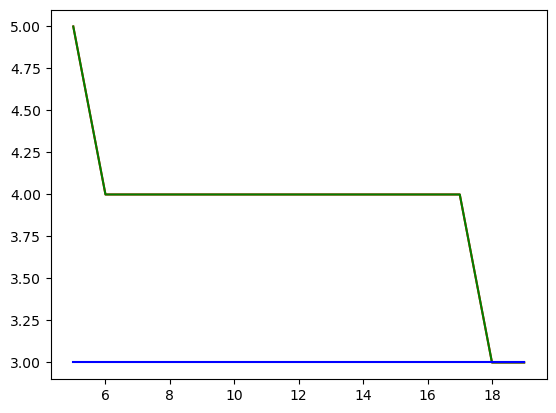

In [107]:
def calculate_density1(k, n):
    return math.ceil(k / (3 - 6/n))

def calculate_density2(k, n):
    return math.floor((k + 3 - 7/n) / (3 - 6/n))

def calculate_density(k):
    return math.ceil((k+1) / 3)

n = list(range(5, 20))
k = 8

y1 = [calculate_density1(k, i) for i in n]
y2 = [calculate_density2(k, i) for i in n]
y3 = [calculate_density(k) for i in n]

plt.plot(n, y1, label='Density 1', color='red')
plt.plot(n, y2, label='Density 2', color='green')
plt.plot(n, y3, label='Density', color='blue')

plt.show()

In [108]:
def random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [109]:
def barabasi_albert_graph(n, m, embedding_layers_number, seed=None, initial_graph=None):
    """Returns a random graph using Barabási-Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási-Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási-Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási-Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    for index, edge in enumerate(G.edges()):
        G.edges[edge]['color'] = 'blue' if index % embedding_layers_number == 0 else 'red'

    if seed is None:
        seed = np.random.RandomState()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        source += 1
    return G

In [110]:
def load_graph_from_file(file_path: str):
    """Draw a graph from a file.

    Parameters
    ----------
    file_path : str
        The path to the file.
    """

    with open(file_path, 'r') as f:
        data = json.load(f)

    G = nx.Graph()

    for node in data['nodes']:
        if 'id' in node and 'color' in node:
            G.add_node(node['id'], color=node['color'])
        elif 'id' in node:
            G.add_node(node['id'])

    for edge in data['edges']:
        if 'source' in edge and 'target' in edge and 'color' in edge:
            G.add_edge(edge['source'], edge['target'], color=edge['color'])
        elif 'source' in edge and 'target' in edge:
            G.add_edge(edge['source'], edge['target'])

    return G

In [127]:
def draw_graph(G: nx.Graph, name: str, pos: dict, hist_max_deg: int):
    """Draw a graph with node and edge colors.

    Parameters
    ----------
    G : nx.Graph
        The graph to draw.
    """

    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(2, 3, figure=fig)
    ax0 = fig.add_subplot(gs[:, :2])
    ax1 = fig.add_subplot(gs[0, 2])
    ax2 = fig.add_subplot(gs[1, 2])

    node_colors = [G.nodes[node]['color'] if 'color' in G.nodes[node] else 'black' for node in G.nodes()]
    edge_colors = [G.edges[edge]['color'] if 'color' in G.edges[edge] else 'black' for edge in G.edges()]
    if pos == None:
        pos = nx.spring_layout(G)
    nx.draw(G, pos, ax=ax0, node_color=node_colors, node_size=50, edge_color=edge_colors, with_labels=False)
    ax0.set_title(name)

    degrees = [G.degree(n) for n in G.nodes()]

    if hist_max_deg == None:
        hist_max_deg = max(degrees) + 2
    ax1.hist(degrees, bins=range(1, hist_max_deg), align='left', color='deepskyblue')
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Frequency")

    degree_counts = np.bincount(degrees)[1:]
    cdf = np.cumsum(degree_counts[::-1])[::-1]
    cdf = cdf / cdf[0]

    nonzero_indices = degree_counts > 0
    k = np.arange(1, len(degree_counts) + 1)[nonzero_indices]
    cdf = cdf[nonzero_indices]

    log_k = np.log(k)
    log_cdf = np.log(cdf)

    slope, intercept, r_value, p_value, std_err = linregress(log_k, log_cdf)
    lambda_estimate = -slope

    ax2.scatter(k, cdf, s=10, alpha=0.75, label='Degree CDF', color='deepskyblue')
    ax2.plot(k, np.exp(intercept) * k ** slope, label=f'Power-law fit: $\\lambda = {lambda_estimate:.2f}$', color='deeppink')

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('CDF')
    ax2.set_title('Degree Distribution and Power-law Fit')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return pos, hist_max_deg

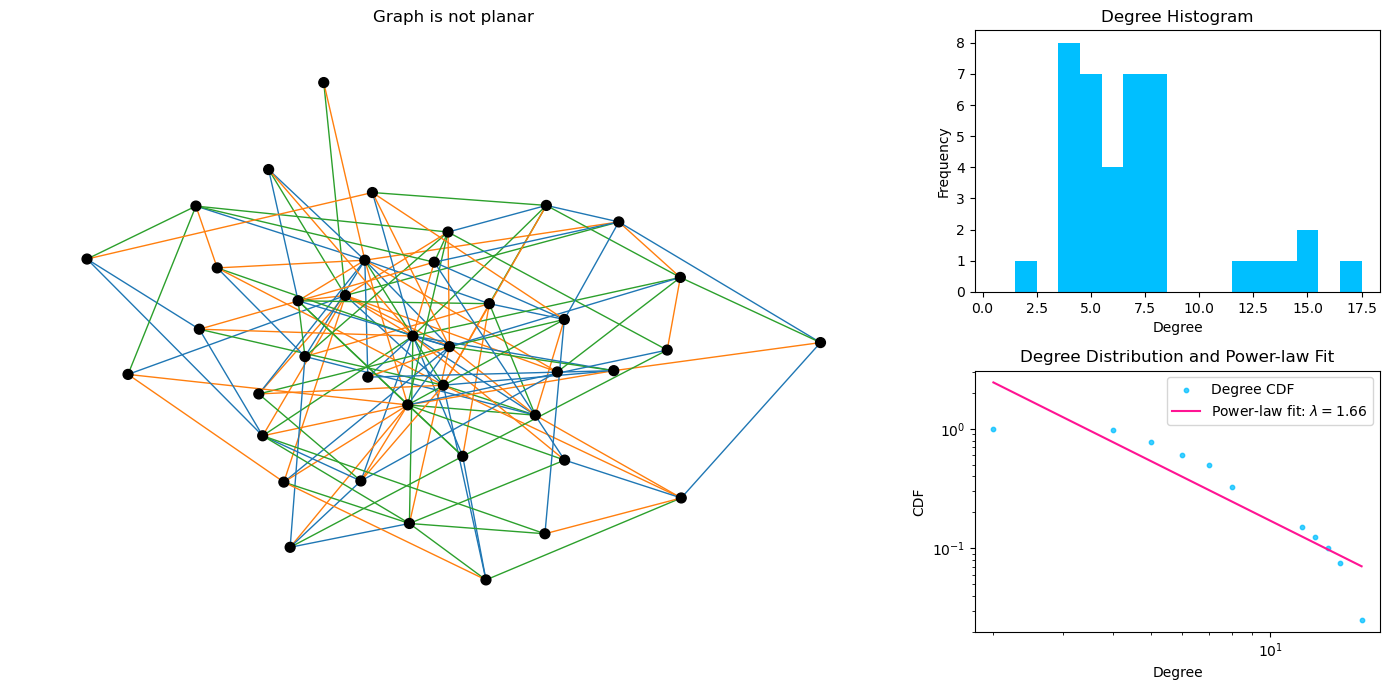

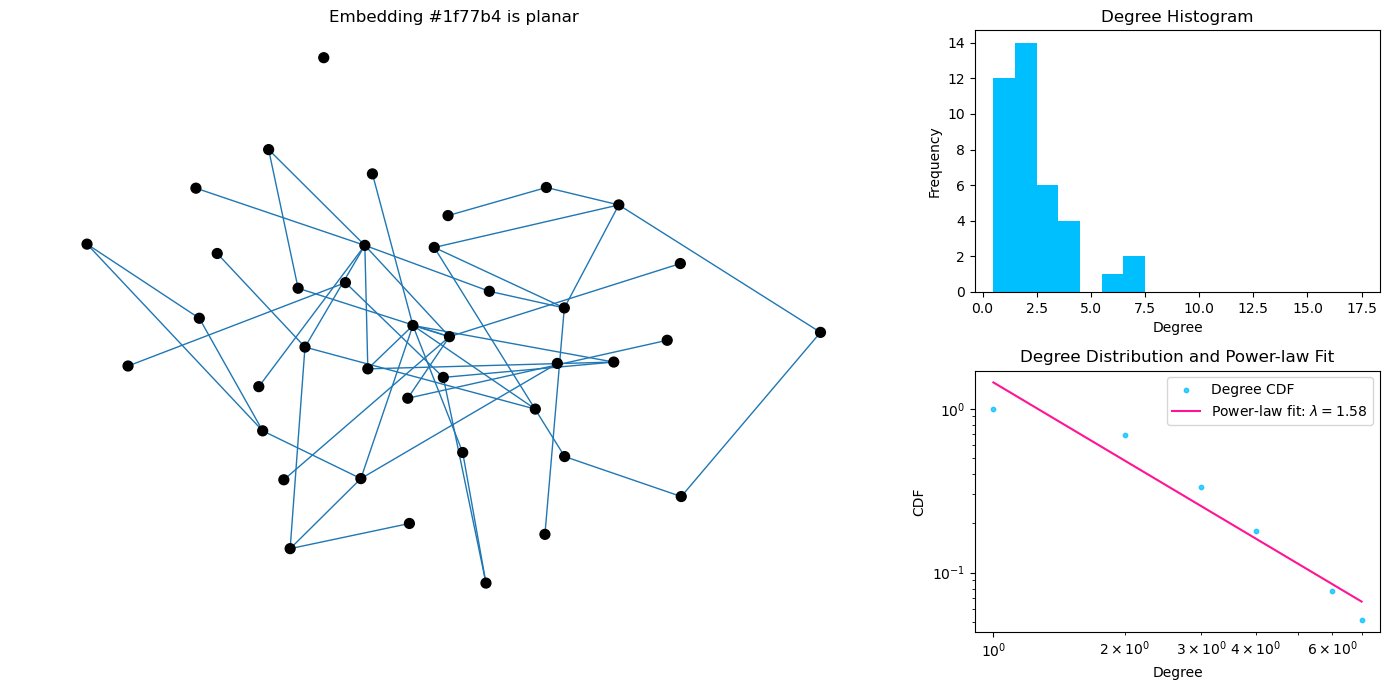

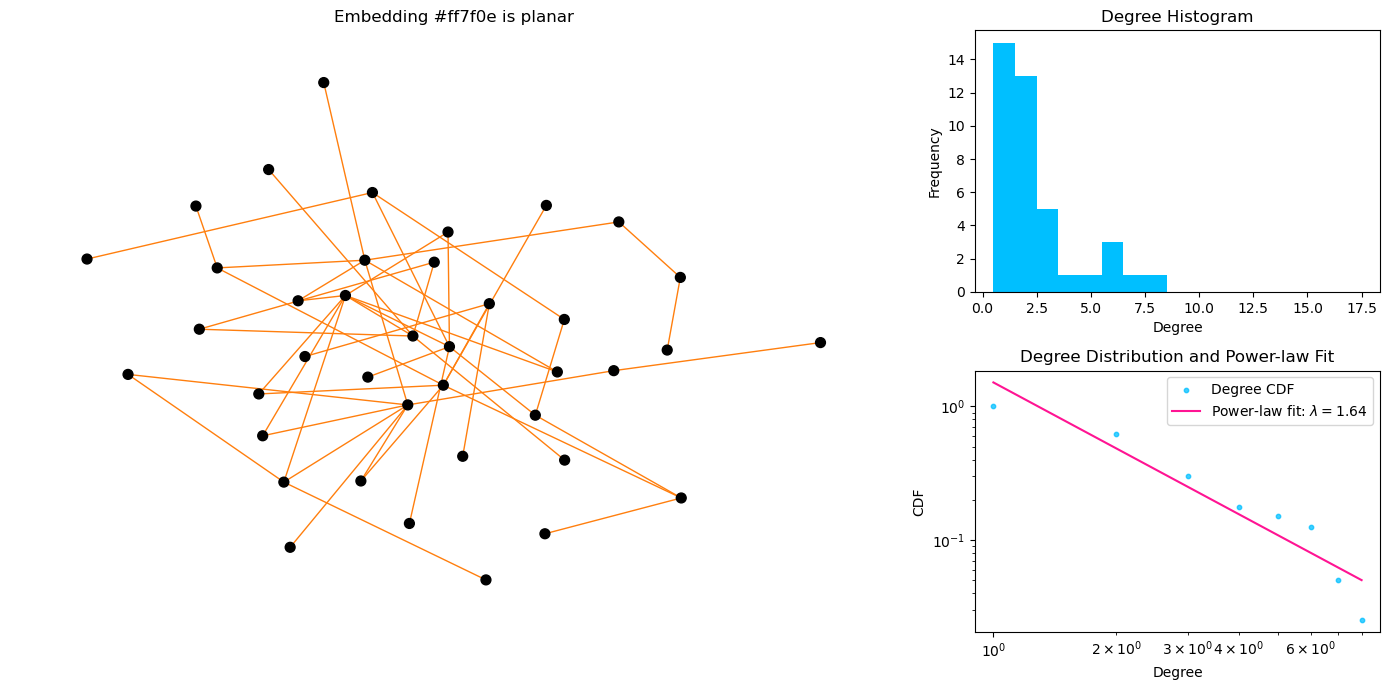

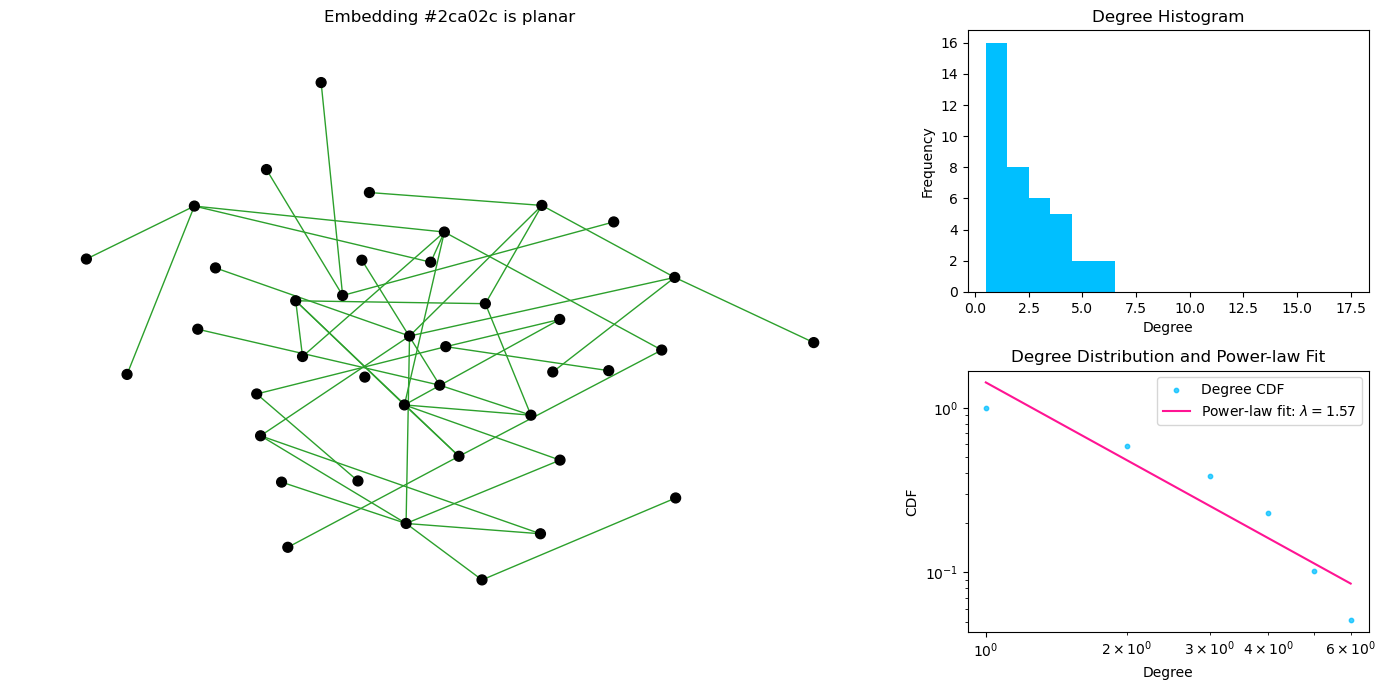

In [129]:
GRAPH_PATH = 'cmake-build-debug/graph1.txt'
EMBEDDING_PATHS = [
    'cmake-build-debug/embedding_#1f77b4.txt',
    'cmake-build-debug/embedding_#ff7f0e.txt',
    'cmake-build-debug/embedding_#2ca02c.txt',
    'cmake-build-debug/embedding_#d62728.txt',
]
EMBEDDING_NUMBERS = 3

ba = load_graph_from_file('cmake-build-debug/graph1.txt')

planar_info = 'is planar' if nx.is_planar(ba) else 'is not planar'
pos, hist_max_deg = draw_graph(ba, 'Graph ' + planar_info, None, None)

for index, embb_path in enumerate(EMBEDDING_PATHS[:EMBEDDING_NUMBERS]):
    embb = load_graph_from_file(embb_path)
    planar_info = ' is planar' if nx.is_planar(embb) else ' is not planar'
    draw_graph(embb, 'Embedding ' + embb_path.split('_')[-1][:-4] + planar_info, pos, hist_max_deg)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
[1687, 1819, 1767, 1690, 1706, 1732, 1617, 1335, 1551, 1524, 1820, 3132, 1416, 1585, 1823, 1824, 1802, 1848, 1898, 3281, 2414, 2176, 2396, 2264, 2271, 2594, 5056, 2965, 2981, 3268, 4481, 3878, 4246, 3910, 8490, 6957, 5803, 6292, 11773, 9525, 11100, 10260, 9721, 14357, 15981, 12335, 13116, 17154, 15070, 20819, 25466, 24402, 25942, 33229, 25797, 37246, 34783, 33095, 36226, 51753, 50528, 66125, 92036, 74460, 92190, 111076, 60858, 73329, 87415, 78577, 102624, 149244, 118453, 124376, 159190, 134907, 202013, 225525, 163918, 208475, 276450, 226788, 256322, 378023, 333

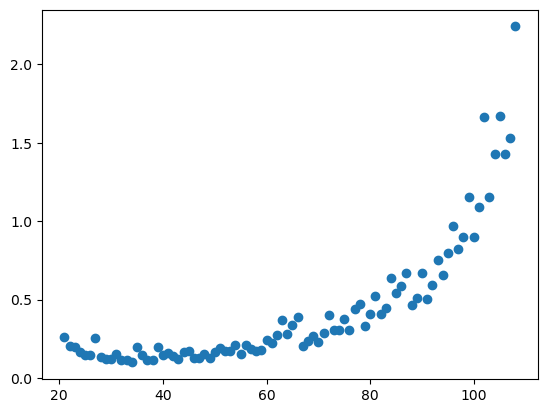

In [121]:
with open('cmake-build-debug/times1.txt') as file:
    xs = []
    ys1 = []
    ys2 = []
    for line in file.readlines():
        x, y = line.strip().split()
        xs.append(int(x))
        ys1.append(int(y))
        ys2.append(int(y) / int(x) ** 3)

    print(xs)
    print(ys1)
    print(ys2)

    # plt.scatter(xs, ys1)
    plt.scatter(xs[20:], ys2[20:])
    # plt.scatter(xs, ys1, c="red")
    # plt.scatter(xs, [x ** 3 for x in xs], c="green")
    # plt.scatter(xs, [0.002 * x ** 4 for x in xs], c="blue")
    plt.show()